<a href="https://colab.research.google.com/github/artbogdanovai/fast_aicourse/blob/master/rice/rice_naive_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trying to solve rice competiton
In pure pytorch instead of fast ai

In [1]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.7 MB/s eta 0:00:00


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import pathlib
import zipfile
import glob
import fastai
from PIL import Image

In [5]:
comp = 'paddy-disease-classification'


In [6]:
creds = '{"username":"artbogdanov","key":"c896dcbee655a8f2bf17e34fc875f65b"}'

In [7]:
os.makedirs(os.path.expanduser('~')+'/.kaggle')

In [8]:
with open(os.path.expanduser('~')+'/.kaggle/kaggle.json', 'w') as f:
    f.write(creds)

In [9]:
import kaggle

In [10]:
!ls 

sample_data


In [11]:
path = pathlib.Path(comp)

In [12]:
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 1.02G/1.02G [00:50<00:00, 21.5MB/s]


In [13]:
example = glob.glob(str(path)+'/train_images/downy_mildew/*')[5]

In [14]:
im = Image.open(example)

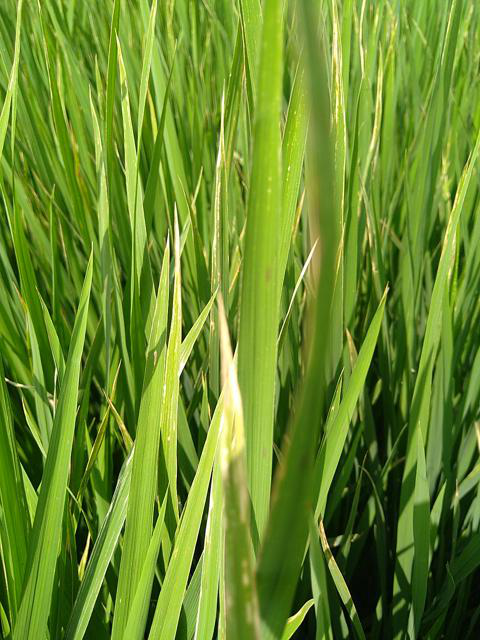

In [15]:
im

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [17]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [35]:
side_size=480

In [36]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize([side_size,side_size]),
     ])
#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [37]:
dataset = torchvision.datasets.ImageFolder(comp+'/train_images',transform)

In [38]:
dataset

Dataset ImageFolder
    Number of datapoints: 10407
    Root location: paddy-disease-classification/train_images
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=[480, 480], interpolation=bilinear, max_size=None, antialias=None)
           )

In [39]:
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(
    dataset, [train_size, valid_size], 
    generator=torch.Generator().manual_seed(42))

In [40]:
batch_size=16

In [41]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

In [42]:
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                          shuffle=True)

In [43]:
dataiter = iter(trainloader)
images, labels = next(dataiter)


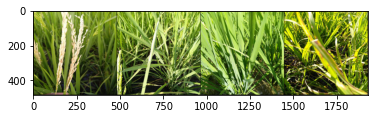

In [44]:
plt.imshow(np.transpose(torchvision.utils.make_grid(images[0:4]), (1, 2, 0)))
plt.show()


In [45]:
images[0].shape

torch.Size([3, 480, 480])

In [46]:
classes = dataset.classes
no_of_classes = len(classes)
classes

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [47]:
no_of_classes

10

In [48]:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

dead_heart hispa normal blast


In [61]:
import torch.nn as nn
import torch.nn.functional as F




class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.fc = nn.Linear(512*30*30, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x,1)
        #print(x.shape)
        x = self.fc(x)
        return x

net = Net()
net = net.to(device)

In [62]:
images.shape

torch.Size([16, 3, 480, 480])

In [63]:
net.forward(images.to(device)).shape

torch.Size([16, 10])

In [64]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [65]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [66]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)